Schaefer (2007): The Hubble Diagram to Redshift >6 from 69 Gamma-ray Bursts
---

In table 6 of this paper, Schaefer presents 6 columns of $\mu$ magnitudes (distance modulus). The first five, subscripted by numerics from 1-5, are the magnitues calculated using five different luminosity-distance relations. The column just following those, which we refer to as `maga`, is the weighted average of these (see calculations for this below). The last column, which we refer to as `magb`, is the distance modulus derived from a Riess cosmolog ($w_0=-1.31$ and $w'=1.48$). 

The distance moduli and their $1\sigma$ uncertainties for all 5 relations: $\mu_1 \pm \sigma_{\mu_1}$, $\mu_2 \pm \sigma_{\mu_2}$, $\mu_3 \pm \sigma_{\mu_3}$, $\mu_4 \pm \sigma_{\mu_4}$, and $\mu_5 \pm \sigma_{\mu_5}$.

Not every GRB has all 5 $\mu$ from the luminosity-distance relations, hence the need for a weighted average. 

The best estimate $\mu$ for each GRB will be the weighted average of all available distance moduli. Thus, the derived distance modulus for each burst will be:

\begin{equation}
\mu = \frac{\sum_{i} \mu_i /\sigma_{\mu_i}^2}{\sum_{i} \sigma_{\mu_i}^{-2}}
\end{equation}

and its uncertainty will be:

\begin{equation}
\sigma_{\mu} = \left( \sum_i \sigma_{\mu_i}^{-2} \right)^{-1/2}
\end{equation}

These are Equation 28-29.

These are weighted averages for each single GRB, not sample statistics. 



In [118]:
from __future__ import division
import os

import numpy as np
import pandas as pd

from numpy import pi, sqrt
from scipy import integrate
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
%matplotlib inline

$D_L$ for Cosmology Models
---

In [111]:
def LumDist_concordance(redshift, H_knot=None, omega_m=None):
    """
    This is the function we use in our work, but different cosmo constants 
    as well as DL units. 
    """
    z           = redshift
    if H_knot is None:
        H_knot      = 71.               # Hubble Constant.  Units: km/s/Mpc
    if omega_m is None:
        omega_m     = 0.27             # Matter Density.
    omega_l     = 1.0 - omega_m
    
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    def Aint(z):
        return (1./(sqrt(((1.+z)*(1.+z)*(1. + omega_m * z))-(z*(2.+ z)*omega_l ))))
    AA      = integrate.quad(Aint, 0.0, z)
    DL_Mpc  = (c * (1. + z) / H_knot) * AA[0]
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc


def LumDist_riess(redshift, H_knot=None, omega_m=None):
    """
    Lower order expansion for dark energy term (w). Equation 14 in Riess et al. 2004. 
    w(z) = w0 + w'z
    """
    z           = redshift
    if H_knot is None:
        H_knot      = 71.               # Hubble Constant.  Units: km/s/Mpc
    if omega_m is None:
        omega_m     = 0.27             # Matter Density.
    omega_l     = 1.0 - omega_m
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    w0 = -1.31
    wp = 1.48   # p: prime symbol
    def Aint(z):
        return 1./np.sqrt( ((1.+z)**3)*omega_m + \
                         omega_l*((1.+z)**(3*(1+w0-wp)))*np.exp(3*wp*z) )
    AA      = integrate.quad(Aint, 0.0, z)
    DL_Mpc  = (c * (1. + z) / H_knot) * AA[0]
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc


def LumDist_weylgravity(redshift, H_knot=None):
    """
    Weyl Gravity.
    Equation 237 in Mannheim 2006 paper
    q_knot      = -0.37 or -0.2
    """
    z           = redshift
    if H_knot is None:
        H_knot      = 71.               # Hubble Constant.  Units: km/s/Mpc
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    q_knot      = -0.37
    DL_Mpc  = (-c * ((1. + z)**2) / (H_knot * q_knot)) * \
                (1-np.sqrt(1 + q_knot - (q_knot/((1+z)**2))))
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc

# def LumDist_wexpansion_2(redshift):
#     H_knot      = 71               # Hubble Constant.  Units: km/s/Mpc
#     omega_m     = 0.27             # Matter Density.
#     omega_l     = 1.0 - omega_m
#     c          = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
#     w0 = -1.31
#     wa = 

#     z = redshift
#     def Aint(z):
#         return 1./np.sqrt( ((1.+z)**3)*omega_m + \
#                          omega_l*((1.+z)**(3*(1+w0+wa)))*np.exp(-3*wz*z/(1+z)) )
#     AA      = integrate.quad(Aint, 0.0, z)
#     DL_Mpc  = (c * (1. + z) / H_knot) * AA[0]
#     DL_pc = DL_Mpc * (1E6)
#     return DL_pc

    
def distance_modulus(lumdistance):
    return 5*np.log10(lumdistance)-5


def get_moduli(model, redshifts=None, H_knot=None, omega_m=None):
    """
    model : str. 'concord', 'weyl', or 'riess'
                    or 'c', 'w', and 'r'
    
    """
    H0 = H_knot
    OM = omega_m
    if model.startswith('c'):   
        DLs = [LumDist_concordance(redshift=z, H_knot=H0, omega_m=OM) for z in redshifts]
    elif model.startswith('r'):   
        DLs = [LumDist_riess(redshift=z, H_knot=H0, omega_m=OM) for z in redshifts]
    elif model.startswith('w'):   
        DLs = [LumDist_weylgravity(redshift=z, H_knot=H0) for z in redshifts]
    moduli = [distance_modulus(lumdistance=dL) for dL in DLs]
    return moduli

In [121]:
def plot_format(xdata, ydata, xerr, yerr, xLims, yLims, ax=None, **pltKwargs):
    if not pltKwargs:
        pltKwargs = dict(fmt='.', color='blue', lw=1, capsize=1)
    plt.clf()
    if ax:
        print('clearning axes')
        ax.clear()
        ax.cla()
    plt.figure(figsize=(5, 3.5))
    if ax is None:
        ax = plt.gca()
    
    #  ***** Plot cosmological models:
    redshifts = np.linspace(0, 7, 100)
    PLT = ax.plot(redshifts, get_moduli(model='c', redshifts=redshifts, H_knot=None, omega_m=None), 
            color='k', alpha=0.35, label='Concorance Cosmology')
    ax.plot(redshifts, get_moduli(model='r', redshifts=redshifts, H_knot=None, omega_m=None), 
            color='red', alpha=0.35, label="Riess: $w(z) = w_0 + w'z$")
    ax.plot(redshifts, get_moduli(model='w', redshifts=redshifts, H_knot=None, omega_m=None), 
            color='blue', alpha=0.35, label='Weyl Gravity') 
        
    # z, mag
    ax.errorbar(xdata, ydata, yerr=yerr, xerr=xerr, **pltKwargs)
    ax.axvline(1.4, 0, 1, alpha=0.75, color='k', ls='--')
    
    ax.minorticks_on()
    ax.set_xlim(*xLims)
    ax.set_ylim(*yLims)
    ax.legend(loc=4, fontsize=11, labelspacing=0.1)
    ax.set_xlabel('$z$', fontsize=14)
    ax.set_ylabel('$\mu$', fontsize=14)
    #plt.show()
    return PLT

### $\mu$ and the uncertainty in $\mu$ ($\sigma_{\mu}$) as given by equations 28 and 29 in Schaefer et al (2007)

In [122]:
# mu = lambda values,errors: np.nansum([i/(j**2) for i,j in zip(values,errors)])/np.nansum([(j**-2.) for j in errors])
# mu_unc = lambda errors: (np.nansum([(j**-2.) for j in errors]))**-0.5

def mu(values, errors):
    a = []
    b = []
    for val,err in zip(values,errors):
        a.append(val/(err**2))
        b.append(err**-2.)
    a = np.nansum(a)
    b = np.nansum(b)
    return a/b

def mu_unc(errors):
    a = []
    for err in errors:
        a.append(err**-2.)
    a = np.nansum(a)
    a = a**-0.5
    return a

Begin Program
---

### Read In Data

In [123]:
# # Supernovae data from Kowalski et al. 2008, table 11
# df1 = pd.read_csv('Kowalski2008_table11.txt', 
#                   sep='\t')

# GRB data from Schaefer 2007, table 6
df = pd.read_csv('Schaefer2007_table6.txt', 
                  sep='\t')
cols = ['mag1', 'mag2', 'mag3', 'mag4', 'mag5'] #, 'maga', 'magb']

cols_vals = ['mag1', 'mag2', 'mag3', 'mag4', 'mag5']
cols_errs = ['mag1_err', 'mag2_err', 'mag3_err', 'mag4_err', 'mag5_err']


bursts = df.GRB.tolist()

In [124]:
df.head()

,GRB,z,mag1,mag1_err,mag2,mag2_err,mag3,mag3_err,mag4,mag4_err,mag5,mag5_err,maga,maga_err,magb,magb_err
0,970228,0.70,NaN,NaN,42.53,1.31,42.41,1.16,NaN,NaN,43.42,1.21,42.79,0.71,42.56,0.70
1,970508,0.84,43.09,1.19,43.13,1.34,45.66,1.04,43.92,0.63,43.09,1.20,43.92,0.43,43.68,0.44
2,970828,0.96,NaN,NaN,42.99,1.28,44.07,1.03,43.61,0.63,43.27,1.25,43.58,0.46,43.32,0.48
3,971214,3.42,48.76,1.50,48.69,1.19,47.55,1.04,NaN,NaN,49.33,1.33,48.44,0.62,48.06,0.61
4,980613,1.10,NaN,NaN,NaN,NaN,45.85,1.33,NaN,NaN,NaN,NaN,45.85,1.33,45.63,1.30


### Check that `maga` is the weighted average

In [125]:
cols_vals = ['mag1', 'mag2', 'mag3', 'mag4', 'mag5']
cols_errs = ['mag1_err', 'mag2_err', 'mag3_err', 'mag4_err', 'mag5_err']

print('         burst   | our calcs    | real values')
print('--'*30)
for burst in df.GRB.tolist():
    values = df.loc[df['GRB'] == burst][cols_vals].values
    errors = df.loc[df['GRB'] == burst][cols_errs].values
    print('%15s: |  %5.2f %5.2f |   %5.2f %5.2f'%(burst, mu(values, errors), mu_unc(errors), 
                                              df.loc[df['GRB'] == burst]['maga'].values, 
                                              df.loc[df['GRB'] == burst]['maga_err'].values))

         burst   | our calcs    | real values
------------------------------------------------------------
         970228: |  42.79  0.71 |   42.79  0.71
         970508: |  43.92  0.43 |   43.92  0.43
         970828: |  43.58  0.46 |   43.58  0.46
         971214: |  48.44  0.62 |   48.44  0.62
         980613: |  45.85  1.33 |   45.85  1.33
         980703: |  44.07  0.40 |   44.07  0.40
         990123: |  44.99  0.45 |   44.99  0.45
         990506: |  44.31  0.57 |   44.31  0.57
         990510: |  45.46  0.40 |   45.46  0.40
         990705: |  43.76  0.46 |   43.77  0.46
         990712: |  41.63  0.53 |   41.63  0.53
         991208: |  41.69  0.67 |   41.69  0.67
         991216: |  43.32  0.42 |   43.32  0.43
            131: |  47.71  0.69 |   47.72  0.69
            210: |  42.45  0.67 |   42.45  0.67
            911: |  45.09  0.68 |   45.10  0.68
            926: |  45.62  0.69 |   45.62  0.69
          10222: |  44.48  0.41 |   44.48  0.42
          10921: |  42.35  0.

In [131]:
for burst in bursts:
    values = df.loc[df['GRB'] == burst][cols_vals].values
    errors = df.loc[df['GRB'] == burst][cols_errs].values
    print(r'%15s:  %15.2f +- %5.2f'%(burst, mu(values, errors), mu_unc(errors)))

         970228:            42.79 +-  0.71
         970508:            43.92 +-  0.43
         970828:            43.58 +-  0.46
         971214:            48.44 +-  0.62
         980613:            45.85 +-  1.33
         980703:            44.07 +-  0.40
         990123:            44.99 +-  0.45
         990506:            44.31 +-  0.57
         990510:            45.46 +-  0.40
         990705:            43.76 +-  0.46
         990712:            41.63 +-  0.53
         991208:            41.69 +-  0.67
         991216:            43.32 +-  0.42
            131:            47.71 +-  0.69
            210:            42.45 +-  0.67
            911:            45.09 +-  0.68
            926:            45.62 +-  0.69
          10222:            44.48 +-  0.41
          10921:            42.35 +-  0.60
          11211:            45.64 +-  0.54
          20124:            46.98 +-  0.43
          20405:            43.67 +-  0.51
          20813:            44.11 +-  0.41
          2

Plots
---

/Users/KimiZ/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log10


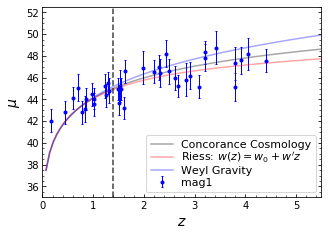

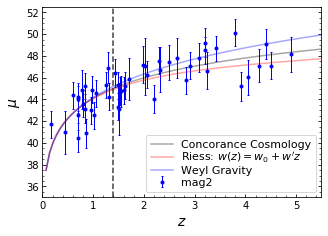

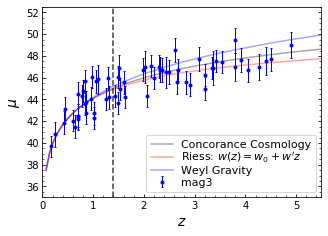

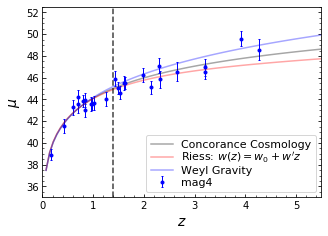

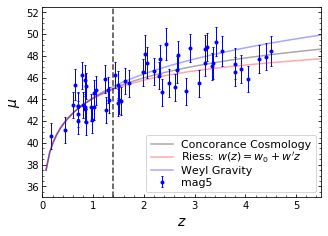

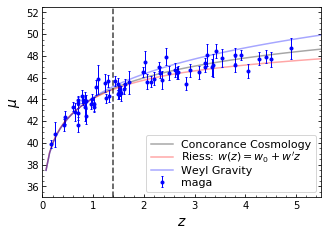

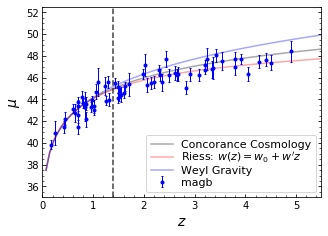

In [126]:
colnames = ['mag1', 'mag2', 'mag3', 'mag4', 'mag5', 'maga', 'magb']

for col in colnames:
    xdata = df.z
    ydata = df[col]
    yerr = df[col+'_err']
    plot_format(xdata=xdata, ydata=ydata, 
                xerr=None, yerr=yerr, 
                xLims=(0, 5.5), 
                yLims=(35, 52.5), ax=None,)# **pltKwargs)
    plt.show()

Check Reiss Cosmology calculation
---

We can't replicate their results exactly since computing $D_L$ with the redshifts of the GRBs and using Riess cosmology will simply plot the curve of the model. Not sure what he did. 

In [127]:
H_knot = 71.
omega_m = 0.27 

ourvalues = np.asarray(get_moduli(model='r', redshifts=df.z, H_knot=H_knot, omega_m=omega_m))

realvalues = df['magb'].values
realerrors = df['magb_err'].values

print(' our calcs    | real values')
print('--'*30)
for i,j in zip(ourvalues, realvalues):
    print('       %5.2f  |   %5.2f '%( i, j))

 our calcs    | real values
------------------------------------------------------------
       43.16  |   42.56 
       43.63  |   43.68 
       43.97  |   43.32 
       46.88  |   48.06 
       44.32  |   45.63 
       44.00  |   43.91 
       45.26  |   44.63 
       44.76  |   43.99 
       45.28  |   45.20 
       43.63  |   43.59 
       41.90  |   41.50 
       43.19  |   41.46 
       44.13  |   43.00 
       47.38  |   47.37 
       43.66  |   42.18 
       44.22  |   44.70 
       45.85  |   45.32 
       45.06  |   44.10 
       42.02  |   42.22 
       45.92  |   45.52 
       46.75  |   46.75 
       43.16  |   43.43 
       44.64  |   43.89 
       40.53  |   40.93 
       46.10  |   46.26 
       44.10  |   43.37 
       46.26  |   46.21 
       45.75  |   46.32 
       46.85  |   46.90 
       45.12  |   44.58 
       39.58  |   39.83 
       46.39  |   46.27 
       43.44  |   44.22 
       43.69  |   43.62 
       43.19  |   43.72 
       44.72  |   45.58 
       44.9

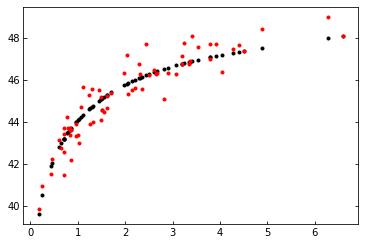

In [128]:
plt.clf()
plt.plot(df.z,ourvalues, '.', color='k')
plt.plot(df.z, realvalues, '.', color='r')
plt.show()

In [29]:
Y = df2.maga.values
X = df2.z.values

In [30]:
popt,pcov = curve_fit(distance_modulus, X, Y)

ValueError: Unable to determine number of fit parameters.

# Add data from Schaefer 2007 (69 GRBs) and Kowalski et al 2008 (414 SN Ia)

The data we will use for the GRBs is the 2nd to last column in Schaefer's Table 6 (column 8). We call it maga because it has a superscript of a and the last column has a superscript of b. All the other columns are assigned numbers 1-5 for subscripts, but not the last two columns. 

In [3]:
# Supernovae data from Kowalski et al. 2008, table 11
df1 = pd.read_csv('Kowalski2008_table11.txt', 
                  sep='\t')

# GRB data from Schaefer 2007, table 6
df2 = pd.read_csv('Schaefer2007_table6.txt', 
                  sep='\t')

In [4]:
import statsmodels.api as sm

In [ ]:
Y = [1,3,4,5,2,3,4]
X = range(1,8)
X = sm.add_constant(X)

In [10]:
range(1,8)

[1, 2, 3, 4, 5, 6, 7]

In [14]:
Y = df2.maga.values
X = df2.z.values 
X = sm.add_constant(X)

In [16]:
model = sm.OLS(Y, X)

In [17]:
results = model.fit()

In [18]:
results.params

array([ 42.79419573,   1.25420335])

In [19]:
results.tvalues

array([ 196.50135026,   14.58954394])

In [20]:
print(results.t_test([1, 0]))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            42.7942      0.218    196.501      0.000      42.360      43.229


In [22]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     212.9
Date:                Sat, 14 Dec 2019   Prob (F-statistic):           1.76e-22
Time:                        23:03:55   Log-Likelihood:                -97.346
No. Observations:                  69   AIC:                             198.7
Df Residuals:                      67   BIC:                             203.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.7942      0.218    196.501      0.000      42.360      43.229
x1             1.2542      0.086     14.590      0.000       1.083       1.426
==============================================================================
Omnibus:                        9.027   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.070
Skew:                          -0.683   Prob(JB):                       0.0107
Kurtosis:                       4.135   Cond. No.                         5.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.757   
Dependent Variable: y                AIC:                198.6923
Date:               2019-12-14 23:04 BIC:                203.1605
No. Observations:   69               Log-Likelihood:     -97.346 
Df Model:           1                F-statistic:        212.9   
Df Residuals:       67               Prob (F-statistic): 1.76e-22
R-squared:          0.761            Scale:              1.0133  
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    42.7942     0.2178   196.5014   0.0000   42.3595   43.2289
x1        1.2542     0.0860    14.5895   0.0000    1.0826    1.4258
-----------------------------------------------------------------
Omnibus:               9.027        Durbin-Watson:          1.889
Prob(Omnibus):         0.011        Jarque-Bera (JB):       9.070
Skew:                  -0.683       Prob(JB):               0.011
Kurtosis:              4.135        Condition No.:          5    
=================================================================

"""

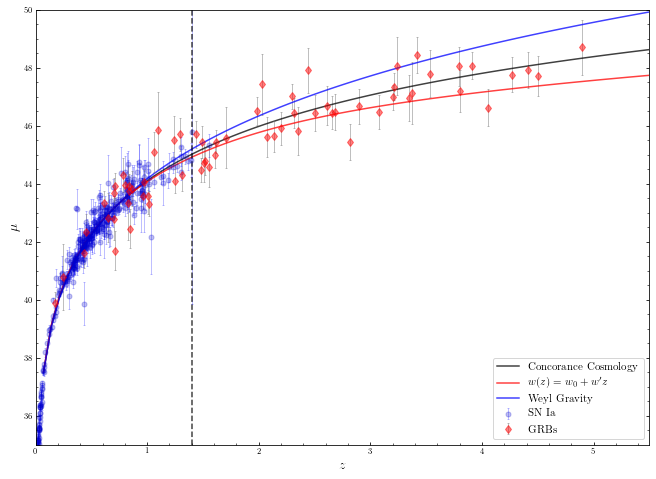

In [8]:
plt.clf()

plt.figure(figsize=(11,8))
plt.plot(xdata, ydata, color='k', alpha=0.75, label='Concorance Cosmology')
plt.plot(xdata2, ydata2, color='red', alpha=0.75, label="$w(z) = w_0 + w'z$")
plt.plot(xdata3, ydata3, color='blue', alpha=0.75, label='Weyl Gravity') 
plt.axvline(1.4, 0,1, alpha=0.75, color='k', ls='--')

# Supernovae
plt.errorbar(df1.z, df1.mag, yerr=df1.mag_err, xerr=None, 
             fmt='o', markersize=5, color='mediumblue', ecolor='blue',
             lw=1, capsize=1, alpha=0.25, label='SN Ia')

# GRBs
plt.errorbar(df2.z, df2.maga, yerr=df2.maga_err, xerr=None, 
             fmt='d', color='red', ecolor='grey',
             lw=1, capsize=1, alpha=0.5, label='GRBs')

plt.minorticks_on()
plt.xlim(0, 5.5)
plt.ylim(35, 50)
plt.legend(loc=0, fontsize=11)
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$\mu$', fontsize=14)
plt.show()

In [ ]:
imp

### Plot for dissertation:

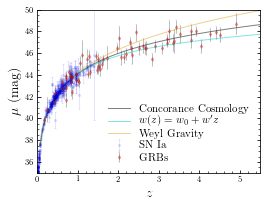

In [28]:
plt.clf()

# plt.plot(xdata, ydata, color='k', alpha=0.75, label='Concorance Cosmology')
# plt.plot(xdata2, ydata2, color='red', alpha=0.75, label="$w(z) = w_0 + w'z$")
# plt.plot(xdata3, ydata3, color='blue', alpha=0.75, label='Weyl Gravity') 
# plt.axvline(1.4, 0,1, alpha=0.75, color='k', ls='--')

plt.plot(xdata, ydata, color='k', alpha=0.5, lw=1,  ls='-', label='Concorance Cosmology')
plt.plot(xdata2, ydata2, color='darkturquoise', alpha=0.5, lw=1, ls='-', label="$w(z) = w_0 + w'z$")
plt.plot(xdata3, ydata3, color='goldenrod', alpha=0.5,  lw=1, ls='-', label='Weyl Gravity') 
#plt.axvline(1.4, 0,1, alpha=0.15, color='k', ls='--')

# Supernovae
plt.errorbar(df1.z, df1.mag, yerr=df1.mag_err, xerr=None, 
             fmt='o', markersize=2, color='mediumblue', ecolor='blue',
             lw=1, capsize=1, alpha=0.1, label='SN Ia')

# GRBs
plt.errorbar(df2.z, df2.maga, yerr=df2.maga_err, xerr=None, 
             fmt='d', markersize=3, color='red', ecolor='grey', 
             markeredgecolor='k', markeredgewidth=0.2, 
             lw=1, capsize=1, alpha=0.5, label='GRBs')

plt.minorticks_on()
plt.xlim(0, 5.5)
plt.ylim(35, 50)
plt.legend(loc=0, fontsize=11, labelspacing=0.2, frameon=False)
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$\mu$ (mag)', fontsize=14)
filename = ('/Users/KimiZ/Documents/MY_DISSERTATION/Thesis/Chapters/Figures/'
            'cosmologicalmodels_withData.pdf')
plt.savefig(filename)
#plt.show()

In [27]:
?plt.legend

In [29]:
os.system('open %s'%filename)

0

In [30]:
df1.shape

(414, 12)

In [31]:
df2.shape

(69, 16)